In [1]:
from google.colab import drive
from google.colab import runtime
import pickle
import matplotlib.pyplot as plt
import numpy as np
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
SIZE_TITLE = 24
SIZE_LABELS = 24
SIZE_TICKS = 18
SIZE_LEGEND = 18

In [3]:
!pip install gdown
!pip install -U pysal
!pip install geopandas
!pip install torch_geometric pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric-temporal
!pip install --upgrade --force-reinstall git+https://github.com/FelipeSchreiber/COE770_Machine_Learning_on_Graphs.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pysal-23.1-py3-none-any.whl (17 kB)
  Using cached libpysal-4.7.0-py3-none-any.whl (2.4 MB)
  Using cached access-1.1.9-py3-none-any.whl (21 kB)
  Using cached esda-2.4.3-py3-none-any.whl
  Using cached giddy-2.3.4-py3-none-any.whl (61 kB)
  Using cached inequality-1.0.0-py3-none-any.whl
  Using cached pointpats-2.3.0-py3-none-any.whl (59 kB)
  Using cached segregation-2.4.2-py3-none-any.whl (147 kB)
  Using cached spaghetti-1.7.3-py3-none-any.whl (50 kB)
  Using cached mgwr-2.1.2-py3-none-any.whl
  Using cached momepy-0.6.0-py3-none-any.whl (275 kB)
  Using cached spglm-1.0.8-py3-none-any.whl
  Using cached spint-1.0.7-py3-none-any.whl
  Using cached spreg-1.3.2-py3-none-any.whl (220 kB)
  Using cached spvcm-0.3.0.tar.gz (5.7 MB)
  Preparing metadata (setup.py) ... done
  Usi

In [4]:
from Tests.benchmark import *

In [ ]:
benchmark = CovidBenchmark()
stats = benchmark.run_test(lags=4,filter_sizes=[2,4,6,8],\
                           train_model=True,\
                           gammas=np.logspace(1,6,num=4).astype(int),\
                           num_epochs=50,\
                           warm_start=True)

In [5]:
stats

{'MSE': [991543.9634284606,
  1053276.7016987463,
  1022212.7612769831,
  936224.117579888,
  991303.7415935905,
  1021922.7359278767,
  1053446.7768368672,
  1053419.9677061464,
  1053447.7298195749,
  994346.206359234,
  1053448.57824091,
  1053300.225916213,
  1021736.6607896617,
  1053407.9936674791,
  1053397.3971731418,
  1086583.710153567],
 'gamma': [10,
  464,
  21544,
  1000000,
  10,
  464,
  21544,
  1000000,
  10,
  464,
  21544,
  1000000,
  10,
  464,
  21544,
  1000000],
 'filter_size': [2, 2, 2, 2, 4, 4, 4, 4, 6, 6, 6, 6, 8, 8, 8, 8]}

In [6]:
with open('covid_test_0.pickle', 'wb') as handle:
    pickle.dump(stats, handle, protocol=pickle.HIGHEST_PROTOCOL)
!cp "/content/covid_test_0.pickle" "/content/drive/MyDrive"

In [5]:
test_0=None
with open("/content/drive/MyDrive/covid_test_0.pickle", 'rb') as handle:
    test_0 = pickle.load(handle)
test_0.keys()

dict_keys(['MSE', 'gamma', 'filter_size'])

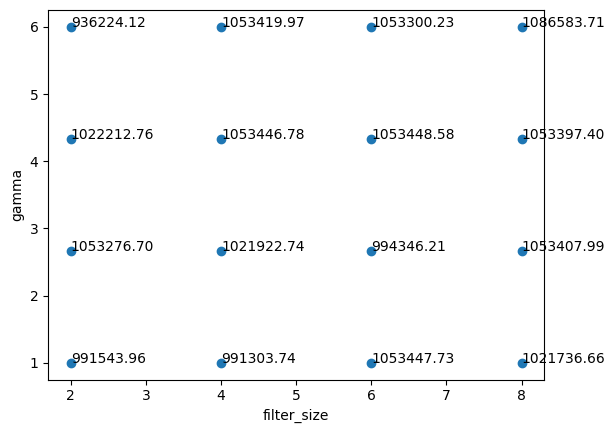

In [7]:
def scatter_(dict_,x_name,y_name,z_name):
  fig, ax = plt.subplots()
  x,y = dict_[x_name],np.log10(dict_[y_name])
  ax.scatter(x,y)
  for i, txt in enumerate(dict_[z_name]):
      ax.annotate("{:.2f}".format(txt), (x[i], y[i]))
  ax.set_xlabel(x_name)
  ax.set_ylabel(y_name)
scatter_(test_0,'filter_size','gamma', 'MSE')

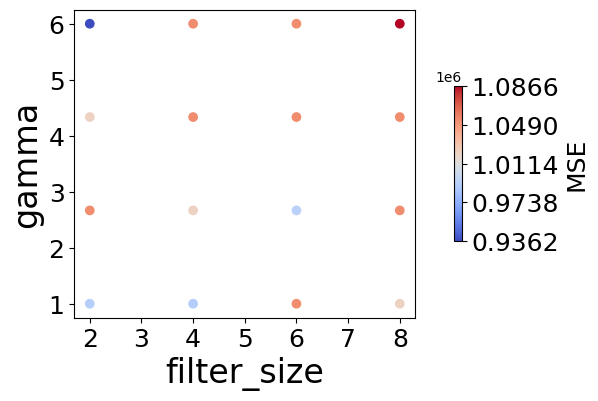

In [8]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
x,y,z = test_0['filter_size'] ,np.log10(test_0['gamma']),test_0["MSE"]
xlabel="filter_size"
ylabel='gamma'
ticks = np.linspace(np.min(z), np.max(z), 5, endpoint=True)
C = ax.scatter(x=x,y=y,c=z,cmap="coolwarm")
cb = fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='MSE',ticks=ticks)
cb.set_label(label='MSE', size=SIZE_LEGEND)
cb.ax.tick_params(labelsize=SIZE_TICKS)
plt.xlabel( xlabel, fontsize = SIZE_LABELS )
plt.ylabel( ylabel, fontsize = SIZE_LABELS )
plt.xticks( fontsize = SIZE_TICKS )
plt.yticks( fontsize = SIZE_TICKS )
plt.show()

In [9]:
loader = CovidDatasetLoader(method="other")
dataset = loader.get_dataset(lags=4)
# train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)
model = get_model(False,num_features=35,num_filters=4,gamma=np.logspace(1,6,num=4).astype(int)[-1])
model.to(device)
model.eval()
cost = 0
preds = []
y = []
for time, snapshot in enumerate(dataset):
    snapshot.to(device)
    y_hat,_ = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    preds.append(y_hat.sum().cpu().detach().numpy())
    y.append(snapshot.y.sum().cpu().detach().numpy())
    cost = cost + torch.mean((y_hat-snapshot.y)**2).item()
    cost = cost / (time+1)
    del snapshot

Downloading...
From: https://drive.google.com/uc?export=download&id=1qLrPQ0IReIzBy26GQDd5MaqQ4IU89s_2
To: /content/caso_full.csv
100%|██████████| 438M/438M [00:03<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1cHVcrjJxDMoLdI_h6YuCdeoz_PE71XqN
To: /content/BR_Municipios_2020.zip
100%|██████████| 190M/190M [00:01<00:00, 98.4MB/s]


onehot:  (5570, 27)


/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 1525, 3499.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1421 disconnected components.
  warnings.warn(message)


[]
Index(['city_ibge_code', 'date', 'epidemiological_week',
       'estimated_population_2019',
       'last_available_confirmed_per_100k_inhabitants',
       'last_available_death_rate', 'last_available_deaths', 'order_for_place',
       'new_confirmed', 'new_deaths'],
      dtype='object')
feat:  757 (5570, 35)


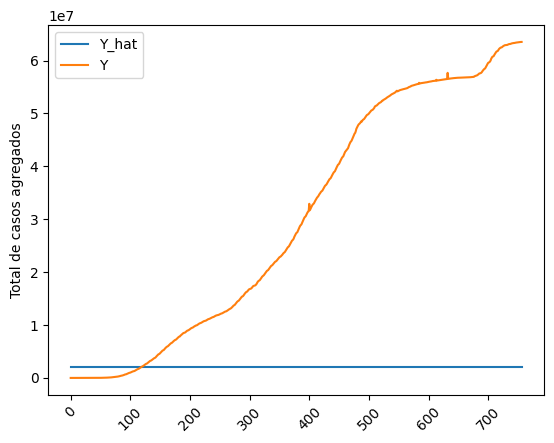

In [10]:
plt.plot(preds,label=f"Y_hat")
plt.plot(y,label=f"Y")
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [12]:
runtime.unassign()